In [26]:
import distutils.util
import subprocess


# Configure MuJoCo to use the EGL rendering backend (requires GPU)
%env MUJOCO_GL=egl

import mujoco

#@title Other imports and helper functions
import numpy as np
from typing import Callable, Optional, Union, List
import scipy.linalg

# Graphics and plotting.
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

# Import Renderer Class
import os
import sys

from controller import Controller
from plotter import Plotter

module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)
from renderer import Renderer
model = mujoco.MjModel.from_xml_path('model/world.xml') #cartpole.xml') #humanoid.xml
data = mujoco.MjData(model)
renderer = Renderer(model, width=640, height=480)

# Make a new camera, move it to a closer distance.
camera = mujoco.MjvCamera()
camera_two = mujoco.MjvCamera()

ballJointQPosAddress = model.joint("rotforce").qposadr[0]
ballJointQPos = data.qpos[ballJointQPosAddress]

mujoco.mjv_defaultFreeCamera(model, camera)
camera.lookat=(ballJointQPos,0,0)
camera.distance = 5
camera.azimuth = 130
camera.elevation = -32

mujoco.mjv_defaultFreeCamera(model, camera_two)
camera_two.lookat=(ballJointQPos,0,0)
camera_two.distance = 8
camera_two.azimuth = 220
camera_two.elevation = -50

DURATION  = 12   # seconds
FRAMERATE = 60  # Hz

# Controller übernimmt resest Optionen und startet später Optimierung, setzten der Startparameter des Ars und der Kugel
controller = Controller(model, data)


model.body("arm").pos = controller.setstartingposarm()
data.joint("rotforce").qpos = controller.setstartingposball()
data = controller.startadhesion()
plotter = Plotter(data.qpos[model.joint("rotforce").qposadr], data.qpos[model.joint("rotforce").qposadr + 1])
model = controller.setstartinganglefromarm()
model = controller.setrotationatstart()
model = controller.setrangeofarm()

frames = []
frames_two = []


env: MUJOCO_GL=egl


Von wo soll der Arm gestartet werden. Geben Sie die y Koordinante ein!
 Sie können dabei Werte zwischen -0.53 und 0.53! 0.5
Um wie viel Grad soll der Arm zur Abwurflinie ausgelenkt sein.
 Geben Sie eine Zahl zwischen -10 und 10 ein. 
 Wie gemessen wird, entnehmen Sie der Readme. 0
Welche Rotation wollen sie haben? Geben sie den Winkel (Ganze Zahl) 
ein den Sie haben möchten (ohne °).
Entsprechendes Beipiel entnehmen Sie der Readme. 75
Um wie viel Grad darf der Arm ausgelenkt werden?
 Geben Sie eine ganze Zahl zwischen 30 und 90 ein. 50


Geben Sie ein wie viel Kraft sie auf die Kugel bringen möchten!
 Sie können dabei Werte zwischen 100 und 1 eingeben! 2


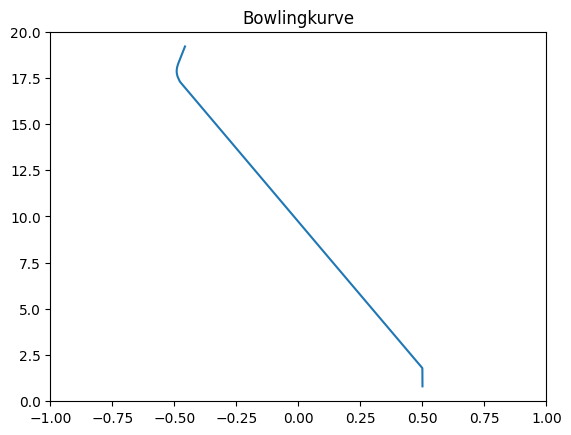

In [27]:
i=-1
while data.time < DURATION:
  # Step the simulation.
    mujoco.mj_step(model, data)
    controller.data = data
    controller.model = model
    
    if data.time > 1 and i == -1:
        data.ctrl[model.actuator("schwung").id] = -5
        i = i + 1
    if data.time > 3 and i == 0 :
        model = controller.revertrangeofarm()
        data.ctrl[model.actuator("rotation").id] = 0.1
        data.ctrl[model.actuator("schwung").id] = controller.setstartingctrl()
        i = i + 1
    if data.qpos[model.joint("rotforce").qposadr] < 19.2 and i == 1:
        model, data = controller.releaseball()
        i = i + 1 
    if 0.8 < data.qpos[model.joint("rotforce").qposadr] < 19.2 and i == 2:
        plotter.updatecurves(data.qpos[model.joint("rotforce").qposadr], data.qpos[model.joint("rotforce").qposadr + 1])
        if 0.8 >= data.qpos[model.joint("rotforce").qposadr]:
            print(data.qvel[model.joint("rotforce").id])
            i = i + 1
    if data.time >= 0.9*DURATION and not controller.resetted:
        controller.checkfalldown()
        data = controller.setsecondthrow()
    
        
# Render and save frames.    
    if len(frames) < data.time * FRAMERATE:
        
        # KAMERA ALLES AB HIER
        
        ballJointQPosAddress = model.joint("rotforce").qposadr[0]
        ballJointQPos = data.qpos[ballJointQPosAddress]      
        
        camera.lookat= (ballJointQPos,0,0)
        camera.elevation = camera.elevation + 0.115
        camera.azimuth = camera.azimuth + 0.225
        
        
        camera_two.lookat=(ballJointQPos,0,0)       
        camera_two.elevation = camera_two.elevation - 0.115
        camera_two.azimuth = camera_two.azimuth - 0.225
        
        # KAMERA 1 VIDEO VORBEREITEN
        renderer.update_scene(data, camera)
        pixels = renderer.render()
        frames.append(pixels.copy())
        
        # KAMERA 2 VIDEO VORBEREITEN (ERST AB BESTIMMTER POSITION)
        if ballJointQPos < 15:
            renderer.update_scene(data, camera_two)
            pixels_two = renderer.render()
            frames_two.append(pixels_two.copy())

media.show_video(frames, fps=FRAMERATE)
plotter.plotcurves()
# AUSKOMMENTIEREN UM ZWEITE KAMERA AUSZUSCHALTEN
media.show_video(frames_two, fps = FRAMERATE)